In [1]:
!pip install opencv-python
!pip install deepface  # For facial emotion recognition
!pip install librosa   # For audio processing
!pip install tensorflow  # For deep learning models
!pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=2be31db1cbc3d38c3f83c9886b9455f080247962e1cdcfb5cfcc4f792656bcde
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


  if event.key is 'enter':



25-05-12 05:54:09 - Directory /root/.deepface has been created
25-05-12 05:54:09 - Directory /root/.deepface/weights has been created
Please upload your video file...


Saving happy1.jpg to happy1.jpg
Processing video frames for facial emotions...
25-05-12 05:54:19 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 105MB/s]


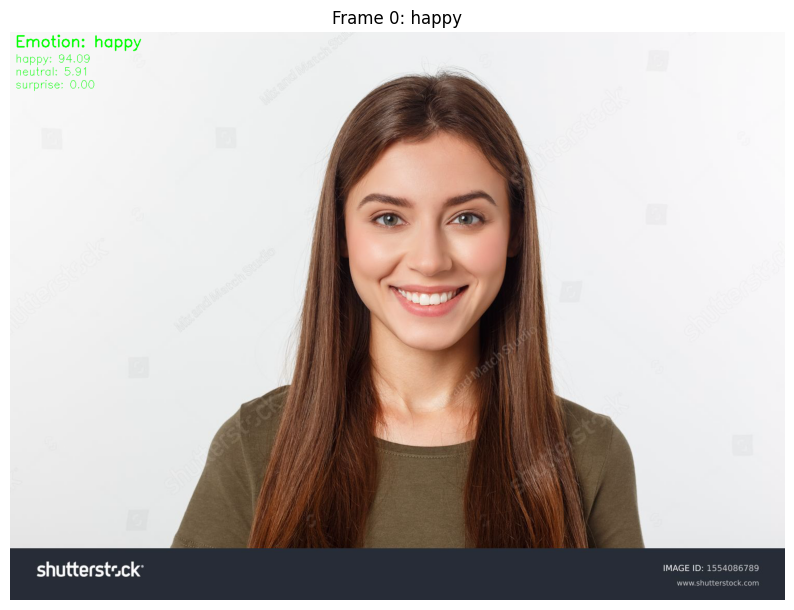


Facial Emotion Summary:
happy: 100.0% (1 frames)

Analyzing audio for vocal emotions...
Error extracting audio: MoviePy error: failed to read the duration of file /tmp/tmpu93jx3tn.mp4.
Here are the file infos returned by ffmpeg:

ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --en

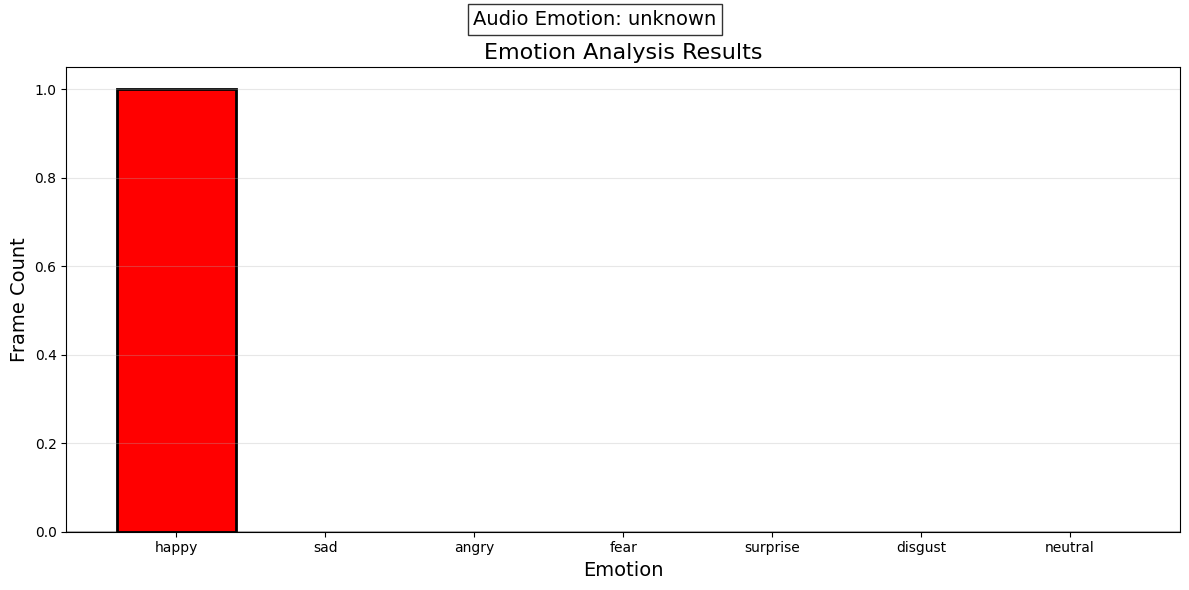

In [2]:
import cv2
import numpy as np
import librosa
import moviepy.editor as mp
from deepface import DeepFace
import matplotlib.pyplot as plt
from google.colab import files
import tempfile
import os
from collections import Counter
import time
from IPython.display import display, clear_output

class MultimodalEmotionDetector:
    def __init__(self):
        self.facial_emotions = []
        self.audio_emotion = "unknown"
        self.overall_emotion = "unknown"

    def upload_video(self):
        print("Please upload your video file...")
        uploaded = files.upload()
        video_path = list(uploaded.keys())[0]


        with tempfile.NamedTemporaryFile(delete=False, suffix='.mp4') as tmp_file:
            tmp_file.write(uploaded[video_path])
            temp_video_path = tmp_file.name

        return temp_video_path

    def analyze_facial_emotion(self, frame):

        try:

            result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
            emotion = result[0]['dominant_emotion']
            emotion_scores = result[0]['emotion']
            return emotion, emotion_scores
        except Exception as e:
            return "unknown", {}

    def process_video_frames(self, video_path, sample_rate=5, max_frames=100):

        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        processed_count = 0

        while cap.isOpened() and processed_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break


            if frame_count % sample_rate == 0:
                emotion, scores = self.analyze_facial_emotion(frame)
                self.facial_emotions.append(emotion)


                if emotion != "unknown":
                    cv2.putText(frame, f"Emotion: {emotion}", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


                    sorted_emotions = sorted(scores.items(), key=lambda x: x[1], reverse=True)
                    y_pos = 60
                    for emo, score in sorted_emotions[:3]:
                        cv2.putText(frame, f"{emo}: {score:.2f}", (10, y_pos),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)
                        y_pos += 25


                plt.figure(figsize=(10, 8))
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"Frame {frame_count}: {emotion}")
                plt.axis('off')
                plt.show()

                processed_count += 1

            frame_count += 1

        cap.release()


        if self.facial_emotions:
            emotion_counts = Counter(self.facial_emotions)
            print("\nFacial Emotion Summary:")
            for emotion, count in emotion_counts.most_common():
                if emotion != "unknown":
                    percentage = (count / len(self.facial_emotions)) * 100
                    print(f"{emotion}: {percentage:.1f}% ({count} frames)")

    def extract_audio(self, video_path):

        try:
            video = mp.VideoFileClip(video_path)
            audio_path = "extracted_audio.wav"
            video.audio.write_audiofile(audio_path, verbose=False, logger=None)
            return audio_path
        except Exception as e:
            print(f"Error extracting audio: {e}")
            return None

    def extract_audio_features(self, audio_path):


        y, sr = librosa.load(audio_path)


        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)


        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)


        chroma = librosa.feature.chroma_stft(y=y, sr=sr)


        rmse = librosa.feature.rms(y=y)
        zcr = librosa.feature.zero_crossing_rate(y)


        features = {
            'mfcc_mean': np.mean(mfccs, axis=1),
            'mfcc_std': np.std(mfccs, axis=1),
            'centroid_mean': np.mean(spectral_centroid),
            'bandwidth_mean': np.mean(spectral_bandwidth),
            'rolloff_mean': np.mean(spectral_rolloff),
            'chroma_mean': np.mean(chroma, axis=1),
            'rmse_mean': np.mean(rmse),
            'zcr_mean': np.mean(zcr)
        }

        return features

    def classify_audio_emotion(self, features):
        """Classify audio emotion based on extracted features"""



        energy = features['rmse_mean']
        zcr = features['zcr_mean']


        if energy > 0.1:
            if zcr > 0.05:
                return "angry"
            else:
                return "happy"
        else:
            if zcr > 0.05:
                return "fear"
            else:
                return "sad"

    def analyze_audio_emotion(self, video_path):
        """Process audio to detect emotions"""
        audio_path = self.extract_audio(video_path)
        if audio_path:
            features = self.extract_audio_features(audio_path)
            self.audio_emotion = self.classify_audio_emotion(features)
            print(f"\nDetected audio emotion: {self.audio_emotion}")


            y, sr = librosa.load(audio_path)
            plt.figure(figsize=(12, 8))

            plt.subplot(2, 1, 1)
            plt.title('Audio Waveform')
            librosa.display.waveshow(y, sr=sr)

            plt.subplot(2, 1, 2)
            plt.title('Mel-frequency spectrogram')
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.tight_layout()
            plt.show()

    def fuse_emotions(self):

        if not self.facial_emotions:
            self.overall_emotion = self.audio_emotion
            return


        valid_emotions = [e for e in self.facial_emotions if e != "unknown"]
        if not valid_emotions:
            self.overall_emotion = self.audio_emotion
            return


        emotion_counts = Counter(valid_emotions)
        dominant_facial_emotion = emotion_counts.most_common(1)[0][0]


        if dominant_facial_emotion == self.audio_emotion:

            self.overall_emotion = dominant_facial_emotion
        else:

            self.overall_emotion = dominant_facial_emotion

    def run_analysis(self, video_path=None, sample_rate=5, max_frames=50):

        if not video_path:
            video_path = self.upload_video()

        print("Processing video frames for facial emotions...")
        self.process_video_frames(video_path, sample_rate, max_frames)

        print("\nAnalyzing audio for vocal emotions...")
        self.analyze_audio_emotion(video_path)

        print("\nFusing modalities for overall emotion assessment...")
        self.fuse_emotions()

        print(f"\nOverall detected emotion: {self.overall_emotion}")


        self.visualize_results()

        return self.overall_emotion

    def visualize_results(self):
        """Visualize the emotion detection results"""
        if not self.facial_emotions:
            return


        emotion_counts = Counter(self.facial_emotions)
        emotions = ['happy', 'sad', 'angry', 'fear', 'surprise', 'disgust', 'neutral']
        counts = [emotion_counts.get(emotion, 0) for emotion in emotions]


        plt.figure(figsize=(12, 6))
        bars = plt.bar(emotions, counts, color=['gold', 'royalblue', 'firebrick',
                                               'darkviolet', 'limegreen', 'darkorange', 'gray'])


        for i, emotion in enumerate(emotions):
            if emotion == self.overall_emotion:
                bars[i].set_color('red')
                bars[i].set_edgecolor('black')
                bars[i].set_linewidth(2)

        plt.title('Emotion Analysis Results', fontsize=16)
        plt.xlabel('Emotion', fontsize=14)
        plt.ylabel('Frame Count', fontsize=14)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.grid(axis='y', alpha=0.3)


        plt.text(0.5, 0.95, f"Audio Emotion: {self.audio_emotion}",
                 horizontalalignment='center', transform=plt.gcf().transFigure,
                 fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()



if __name__ == "__main__":
    detector = MultimodalEmotionDetector()
    detector.run_analysis()